### Analýza datasetu

Zobrazení kořenové struktury datasetu.

In [35]:
from pathlib import Path

space =  '    '; branch = '│   '; tee =    '├── '; last =   '└── '
def tree(dir_path: Path, prefix: str='', exclude_extensions=None):
    if exclude_extensions is None: exclude_extensions = ['.jpg']
    if isinstance(dir_path, str): dir_path = Path(dir_path)
    # Filter out files with excluded extensions
    contents = [p for p in dir_path.iterdir()  if not (p.is_file() and p.suffix.lower() in exclude_extensions)]
    if not contents: return
    # contents each get pointers that are ├── with a final └── :
    pointers = [tee] * (len(contents) - 1) + [last]
    for pointer, path in zip(pointers, contents):
        yield prefix + pointer + path.name
        if path.is_dir():  # extend the prefix and recurse:
            extension = branch if pointer == tee else space
            # i.e. space because last, └── , above so no more |
            yield from tree(path, prefix=prefix+extension, exclude_extensions=exclude_extensions)

for line in tree('./nikitarom'):
    print(line)

└── planets-dataset
    ├── 3.complete
    └── versions
        └── 3
            ├── planet
            │   └── planet
            │       ├── sample_submission.csv
            │       ├── test-jpg
            │       ├── train-jpg
            │       └── train_classes.csv
            └── test-jpg-additional
                └── test-jpg-additional


První csv tabulka s názvem **sample_submission.csv** obsahuje 61191 hodnot, obsahuje 2 sloupce: image_name - název daného obrázku tags - popis vlastností toho co je na obrázcích.

Druhá csv tabulka s názvem **train_classes.csv** obsahuje 40 479 hodnot obsahuje také 2 sloupce: image_name - název daného obrázku tags - popis vlastností toho co je na obrázcích např.: clear_primary, clear_cloudy_primary, atd...

Máme adresáře pro obrázky:

**test-jpg**, kde se nachází testovací obrázky, je jich přibližně 40 000.

**train-jpg**, kde se nachází trénovací obrázky, je jich přibližně 40 000.

**test-jpg-additional**, kde se nachází testovací ještě nachází přibližně 20 500 testovacích obrázků navíc.



### Načtení dat pro trénovací model

In [200]:
#import potřebných datasetů
import os
import pandas as pd
import numpy as np
import seaborn as sns
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, multilabel_confusion_matrix, classification_report, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Nastavení cest k datům
DATA_DIR = './nikitarom/planets-dataset/versions/3/'
TRAIN_DIR = os.path.join(DATA_DIR, 'planet/planet/train-jpg')
TEST_DIR = os.path.join(DATA_DIR, 'planet/planet/test-jpg')
TRAIN_CLASSES = os.path.join(DATA_DIR, 'planet/planet/train_classes.csv')
SUBMISSION = os.path.join(DATA_DIR, 'planet/planet/sample_submission.csv')

# Načtení CSV souborů
train_df = pd.read_csv(TRAIN_CLASSES)
submission_df = pd.read_csv(SUBMISSION)


Naimportoval jsem potřebné datasety pro práci s daty. Určil jsem si cesty k adresářům s trénovací a testovacími obrázky a s popisem obrázků. Načetl jsem si csv soubory.

#### Zjišťovaní informací o tabulce

In [24]:
print(f"Počet trénovacích záznamů: {len(train_df)}")
print(f"Počet testovacích záznamů: {len(submission_df)}")

# Zobrazení informací o tabulce
print('\nZobrazení informací o trénovací tabulce:')
print("Hlavička tabulky: \n", train_df.head(), '\n')
print("Informace o tabulce: ", train_df.info(), '\n')
print("Nulové hodnoty: ", train_df.isnull().sum(), '\n')

# Zobrazme si distribuci tagů ve sloupci 'tags'
all_tags = []
for tags in train_df['tags'].values:
    all_tags.extend(tags.split())
unique_tags = sorted(list(set(all_tags)))
print(f"\nPočet unikátních tagů: {len(unique_tags)}")
print(f"Unikátní tagy: {unique_tags}")


Počet trénovacích záznamů: 40479
Počet testovacích záznamů: 61191

Zobrazení informací o trénovací tabulce:
Hlavička tabulky: 
   image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40479 entries, 0 to 40478
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  40479 non-null  object
 1   tags        40479 non-null  object
dtypes: object(2)
memory usage: 632.6+ KB
Informace o tabulce:  None 

Nulové hodnoty:  image_name    0
tags          0
dtype: int64 


Počet unikátních tagů: 17
Unikátní tagy: ['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloud

Vypsal jsem si informace o tabulce, abych věděl kolik s ní je záznamů, jak má nastavené sloupce, jestli tam například jsou povoleny nulové hodnoty a jakého typu jsou. Také jsem si vypsal informace o tom, jestli obsahuje nějaké nulové hodnoty a kolik je tagů ve sloupci *tags*, kde jsem zjistil, že se vyskytuje 17 různých tagů pro popis obrázků.

Unikátní tagy:

agriculture, artisinal_mine, bare_ground, blooming, blow_down, clear, cloudy, conventional_mine, cultivation, habitation, haze, partly_cloudy, primary, road, selective_logging, slash_burn, water

In [25]:
# Zobrazení informací o testovací tabulce
print('\nZobrazení informací o testovací tabulce:')
print("Hlavička tabulky: \n", submission_df.head(), '\n')
print("Informace o tabulce: ", submission_df.info(), '\n')
print("Nulové hodnoty: ", submission_df.isnull().sum(), '\n')

test_all_tags = []
for tags_str in submission_df["tags"].values:
    test_all_tags.extend(tags_str.split())
test_unique_tags = sorted(list(set(test_all_tags)))
print(f"\nPočet tagů v testovacích datech: {len(test_unique_tags)}")
print(f"Tagy: {test_unique_tags}")


Zobrazení informací o testovací tabulce:
Hlavička tabulky: 
   image_name                                  tags
0     test_0  primary clear agriculture road water
1     test_1  primary clear agriculture road water
2     test_2  primary clear agriculture road water
3     test_3  primary clear agriculture road water
4     test_4  primary clear agriculture road water 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61191 entries, 0 to 61190
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  61191 non-null  object
 1   tags        61191 non-null  object
dtypes: object(2)
memory usage: 956.2+ KB
Informace o tabulce:  None 

Nulové hodnoty:  image_name    0
tags          0
dtype: int64 


Počet tagů v testovacích datech: 5
Tagy: ['agriculture', 'clear', 'primary', 'road', 'water']


Zobrazení informací o testovací tabulce. Zde je v informacích o tabulce vidět, že testovací tabulka nemá rozdělené tagy a v každém sloupci je napsáno 5 možných tagů.

#### Analýza frekvence tagů
Abych měl přehled o tom kolikrát se který tag v trénovací tabulce vyskytuje.


Nejčastější tagy:
primary: 37513 výskytů
clear: 28431 výskytů
agriculture: 12315 výskytů
road: 8071 výskytů
water: 7411 výskytů
partly_cloudy: 7261 výskytů
cultivation: 4547 výskytů
habitation: 3660 výskytů
haze: 2697 výskytů
cloudy: 2089 výskytů


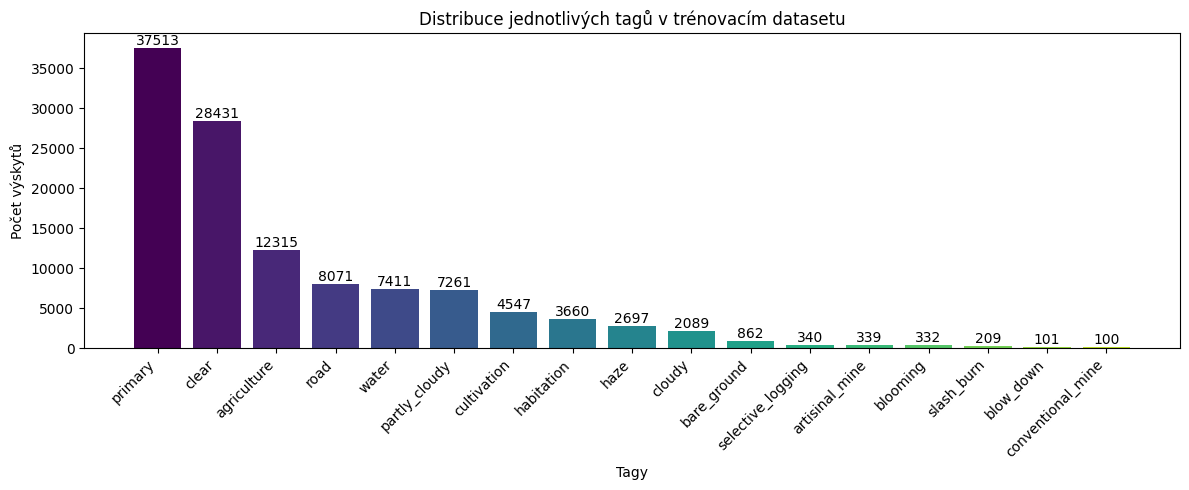

In [26]:
tag_counts = {}
for tag in all_tags:
    if tag in tag_counts: tag_counts[tag] += 1
    else: tag_counts[tag] = 1

sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)
print("\nNejčastější tagy:")
for tag, count in sorted_tags[:10]:
    print(f"{tag}: {count} výskytů")

def plot_tag_distribution(sorted_tags):
    tags = [tag for tag, _ in sorted_tags]
    counts = [count for _, count in sorted_tags]
    plt.figure(figsize=(12, 5))
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(tags)))
    bars = plt.bar(range(len(tags)), counts, color=colors)
    plt.xlabel('Tagy'); plt.ylabel('Počet výskytů'); plt.title('Distribuce jednotlivých tagů v trénovacím datasetu')
    plt.xticks(range(len(tags)), tags, rotation=45, ha='right')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1, f'{int(height)}', ha='center', va='bottom')
    plt.tight_layout(); plt.savefig('tags_distribution_train.png'); plt.show(); plt.close()

plot_tag_distribution(sorted_tags)

### Trénování dat a vytvoření klasifikátorů

#### Vytvoření one-hot encodingu pro tagy
Abych mohl s tagy u obrázků trénovacím modelu pracovat, tak si musím data převét na vektory, abych s nimi mohl pracovat v PyTorch, kde je poté pomocí tensoru převeden na formát vektorů ve floatech, s kterým bude pracovat trénovací model. Vypíšem si hlavičku datasetu a je tam vidět nový vytvořený sloupec, kde u každého záznamu je udělaný vektor pole, který má 17 hodnot ve formátu floatu, které buďto reprezentují 1.0(True) a nebo 0.0(False) hodnotu, podle toho jestli dané tagy obrázek obsahuje. Jeden obrázek může mít víc tagů.

In [27]:
# Vytvoření one-hot encodingu pro tagy
def get_tag_map(tags):
    labels = np.zeros(len(unique_tags))
    if pd.isna(tags): return labels
    for tag in tags.split():
        if tag in unique_tags:
            labels[unique_tags.index(tag)] = 1
    return labels
# Přidání one-hot encodingu do dataframe
train_df['tag_vector'] = train_df['tags'].apply(get_tag_map)
print(train_df.head())

  image_name                                       tags  \
0    train_0                               haze primary   
1    train_1            agriculture clear primary water   
2    train_2                              clear primary   
3    train_3                              clear primary   
4    train_4  agriculture clear habitation primary road   

                                          tag_vector  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...  
4  [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...  


#### Vytvoření dataset třídy pro PyTorch DataLoader
Abych mohl trénovat data v Resnet50, tak si musím vytvořit dataset třídu pro PyTorch. V této třídě si určím dataframe, s kterým budu pracovat, adresář pro obrázky a typ transformace pro dané obrázky. Je tu funkce, která mi vrací délku dataframu a funkce __getitem__, která načte obrázky, aplikuje na ně transformaci. Pomocí FloatTensor v PyTorch převede pro sloupec tag_vector obsahující vektory tagů, převede vektory tagů ve floatu do multi-dimensionální matice obsahující elementy daného datového typu k trénování datasetu a potom vrátíme vytvořený dataset pro zpracování s obrázky a tag vektorem.

In [28]:
# Vytvoření vlastní Dataset třídy pro PyTorch
class PlanetDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['image_name']
        img_path = os.path.join(self.img_dir, img_name + '.jpg')
        # Načtení obrázku
        image = Image.open(img_path).convert('RGB')
        # Aplikace transformací, pokud jsou definované
        if self.transform: image = self.transform(image)
        # Získání one-hot encodingu pro tagy
        tag_vector = torch.FloatTensor(self.dataframe.iloc[idx]['tag_vector'])
        return image, tag_vector

In [29]:
# Výpočet adekvátního průměru a směrodatné odchylky pro normalizaci
def calculate_mean_std(dataset):
    temp_transform = transforms.Compose([ transforms.Resize((224, 224)), transforms.ToTensor()])
    # Dočasně změnit transformace datasetu
    original_transform = dataset.transform
    dataset.transform = temp_transform
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)
    mean = torch.zeros(3); std = torch.zeros(3) # udělat si prázdné pole o velikosti 3 pro std a mean
    total_samples = 0
    # výpočet mean
    for data, _ in dataloader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        total_samples += batch_samples
    mean = mean / total_samples
    # výpočet std
    for data, _ in dataloader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        std += ((data - mean.unsqueeze(1))**2).sum([0,2])
    std = torch.sqrt(std / (total_samples * 224 * 224))
    # Vrátit původní transformace
    dataset.transform = original_transform
    print(f"mean: {mean}, std: {std}")
    return mean.tolist(), std.tolist()
mean, std = calculate_mean_std(PlanetDataset(train_df, TRAIN_DIR, transform=None))

mean: tensor([0.3117, 0.3408, 0.2991]), std: tensor([0.1669, 0.1436, 0.1372])


#### Definování transformace
Nadefinujem si transformaci pro trénovací a validační data, která bude použita pro trénování modelu. Můžem si nadefinovat zvlášť transformaci pro trénovací data a pro validační data.

U transformace si můžeme určit.:
- U jaké velikosti v pixelech chceme začít.
- Jestli je převedeme na tensor.
- Jestli chceme obrázek náhodně otáčet horizontálně nebo vertikálně. Tohle se hodně hodí pro obrázky tohoto typu, protože dané obrázky mohou být jakkoliv vyfoceny. 
- Náhodnou rotaci, u které si určíme počet stupňů.
- Můžem si upravit obraz, jaký chceme mít jas, kontrast, sytost, a další...
- Přidat GaussianBlur gausovské rozostření, které simuluje atmosférické podmínky.
- Normalizaci dat, kde určíme průměr a směrodatnou odchylku na třídimenzionální data transformovaní obrázků. Například, když jsem si vytvořil algoritmus pro vytvoření mean a std pro normalizaci, spočítal mi u mean: 0.3117, 0.3408, 0.2991 a u std: 0.1669, 0.1436, 0.1372
- A spoustu dalších vlastností...

In [ ]:
# Definování transformací pro obrázky
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    #transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)), #jemný blur,  sigma od 0.1 slabé do 1.5 středně silné hodnoty rozmazání
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

#### Rozdělení na trénovací data a jejich připracení pro trénování modelu
Model si rozdělím na trénovací a validační data. Nastavím si rozdělení trénovacích dat a validačních dat 80/20 a random_state pro zamíchání dat. Následně si vypíši kolik tam je trénovacích a validačních vzorků Vytvořím si datasety pro trénovací a validační data podle třídy PlanetDataset definované pro train model pomocí torch. 


Počet trénovacích vzorků: 32383
Počet validačních vzorků: 8096


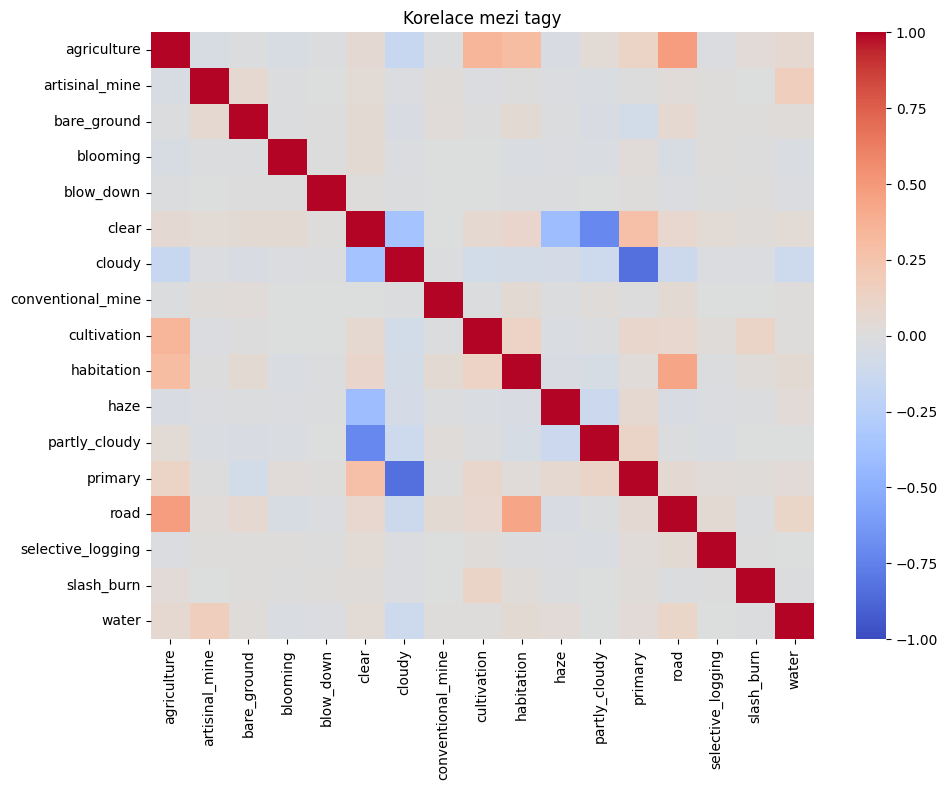

In [65]:
train_data, valid_data = train_test_split(train_df, test_size=0.2, random_state=42)
print(f"\nPočet trénovacích vzorků: {len(train_data)}")
print(f"Počet validačních vzorků: {len(valid_data)}")
# Vytvoření datasetů
train_dataset = PlanetDataset(train_data, TRAIN_DIR, transform=train_transform)
valid_dataset = PlanetDataset(valid_data, TRAIN_DIR, transform=val_transform)

def visualize_class_correlations(dataset, unique_tags):
    num_tags = len(unique_tags); correlation_matrix = np.zeros((num_tags, num_tags))
    # Sběr všech labelů
    all_labels = []
    for _, label in dataset:
        all_labels.append(label.numpy())
    all_labels = np.array(all_labels)
    # Výpočet korelací mezi tagy
    for i in range(num_tags):
        for j in range(num_tags):
            correlation_matrix[i, j] = np.corrcoef(all_labels[:, i], all_labels[:, j])[0, 1]
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, xticklabels=unique_tags, yticklabels=unique_tags, cmap='coolwarm', vmin=-1, vmax=1, annot=False)
    plt.title('Korelace mezi tagy'); plt.tight_layout(); plt.show()
visualize_class_correlations(train_dataset, unique_tags)


Zde jsem si udělal korelační matici mezi třídami, abych měl přehled v datasetu o některých kritických třídách a jejich výskytu. 

In [100]:
def set_critical_class_weights(unique_tags, tag_distribution, threshold=0.05):
    weights = torch.ones(len(unique_tags))
    ## Identifikace velmi vzácných tříd (méně než 5% dat)
    #total_samples = sum(tag_distribution.values())
    #threshold_percentage = 0.05
    #critical_classes = []
    #for i, tag in enumerate(unique_tags):
    #    count = tag_distribution[tag]
    #    percentage = count / total_samples
    #    if percentage < threshold_percentage:
    #        weights[i] = 2.0  # Základní zvýšení pro vzácné třídy
    #        critical_classes.append((i, tag, percentage))
    # Přidání vah pro doménově kritické třídy
    domain_critical = ["slash_burn","blow_down", "conventional_mine", "artisinal_mine", "blooming", "selective_logging","bare_ground","haze","habitation","cultivation"]
    for tag in domain_critical:
        if tag in unique_tags:
            idx = unique_tags.index(tag)
            weights[idx] = max(weights[idx], 2)  # Vyšší váha pro doménově kritické třídy
    # Výpis nastavených vah
    print("Nastavené vyšší váhy pro kritické třídy:")
    for i, tag in enumerate(unique_tags):
        if weights[i] > 1.0:
            print(f"{tag}: {weights[i]:.2f}")
    return weights

class_weights = set_critical_class_weights(unique_tags, tag_counts)

Nastavené vyšší váhy pro kritické třídy:
artisinal_mine: 2.00
bare_ground: 2.00
blooming: 2.00
blow_down: 2.00
conventional_mine: 2.00
cultivation: 2.00
habitation: 2.00
haze: 2.00
selective_logging: 2.00
slash_burn: 2.00


Nastavil jsem vyšší váhy pro některé třídy.

#### Načtení dat do DataLoaderu a jejich vizualizace.

Datasety si načtu do DataLoaderu obsahující dávky (iterace) dat pomocí funkce z PyTorch, abych z nich mohl udělat trénovací model, ve kterých si určím batch size, který obvykle bývá 32, jestli je chci zamíchat a počet workerů na kolika vláknech se mi to bude načítat. Vícevláknové načítání může někdy způsobit problém, že se data načítají delší dobu nebo deadlock. A potom si můžu vypsat ukázku načtení jedné dávky dat obrázků a labelů z train DataLoaderu. Tato operace, pokud těch dat je hodně, může už trvat dlouhou dobu. Můžu si vypsat, jak vypadá taková jedna dávka dat připravená pro vytvoření trénovacího modelu pomocí resnet50. Vizualizuji si obrázky z datasetu. Na konci si ještě můžu nastavit hodnoty deformací obrázků pro průměr a smerodatnou odchylku, poté už jsou data připravena pro trénování.


Tvar načtených obrázků: torch.Size([32, 3, 224, 224])
Tvar načtených tagů: torch.Size([32, 17])
Čas pro načtení dat do DataLoaderu:  0.26706600189208984  s


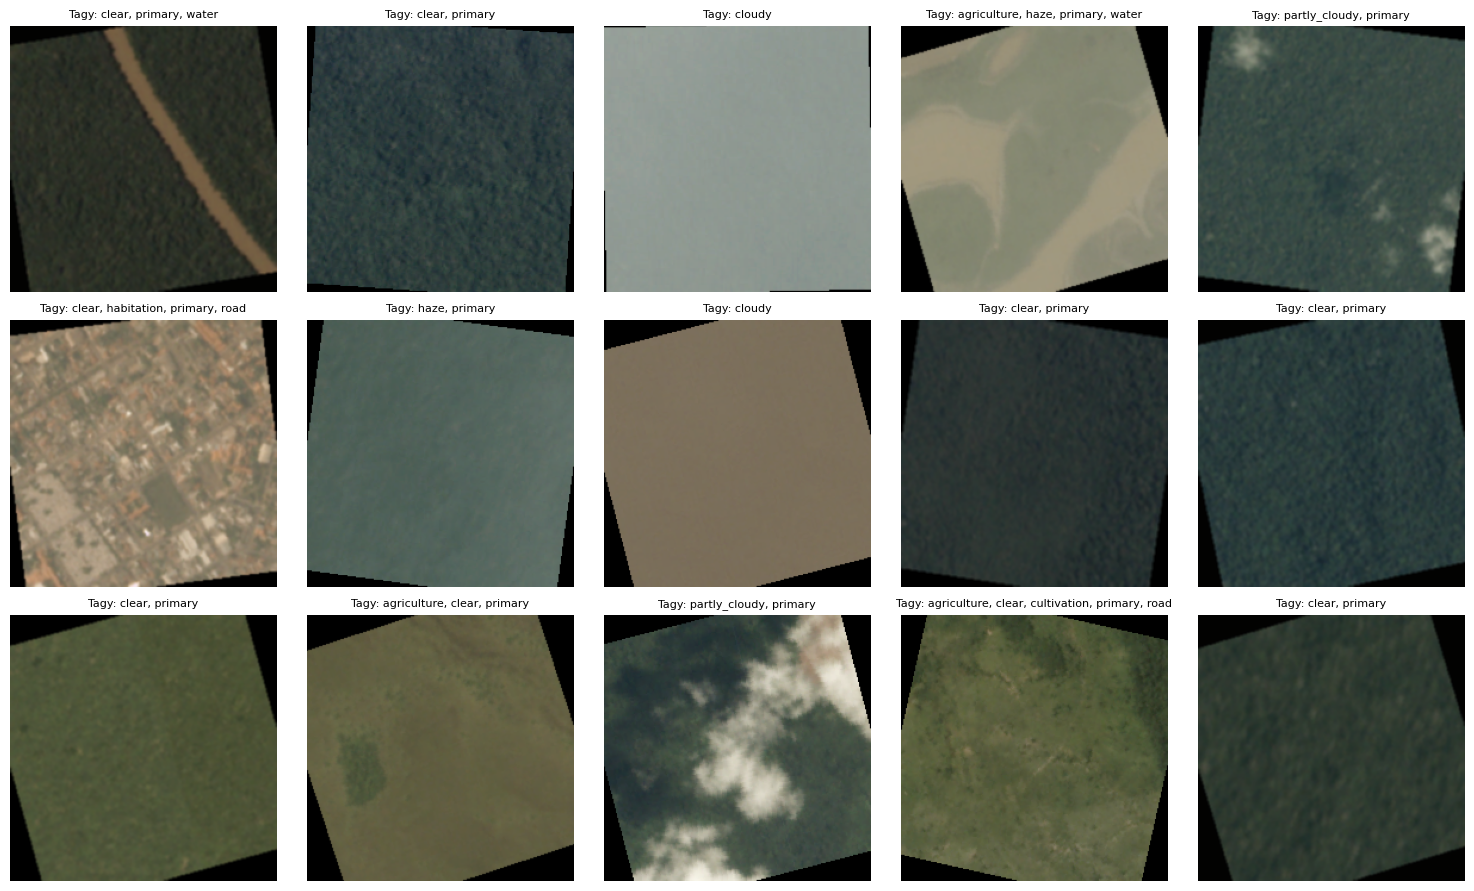


Data jsou připravena pro trénování modelu!


In [101]:
# Vytvoření dataloaderů
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
# Ukázka načtení jedné dávky dat
start_time = time.time()
images, labels = next(iter(train_loader))
end_time = time.time()
print(f"\nTvar načtených obrázků: {images.shape}")
print(f"Tvar načtených tagů: {labels.shape}")
print("Čas pro načtení dat do DataLoaderu: ", end_time - start_time, " s")
# Vizualizace několika obrázků z datasetu
mean = mean; std = std #mean = [0.485, 0.456, 0.406]; std = [0.229, 0.224, 0.225]
def visualize_sample(dataset, num_samples=15):
    num_rows = (num_samples + 5 - 1) // 5
    plt.figure(figsize=(15, 3*num_rows))
    for i in range(num_samples):
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy()
        # Denormalizace obrázku pro zobrazení
        image = std * image + mean
        image = np.clip(image, 0, 1)
        tags = [unique_tags[j] for j in range(len(unique_tags)) if label[j] == 1]
        plt.subplot(num_rows, 5, i+1)
        plt.imshow(image)
        plt.title(f"Tagy: {', '.join(tags)}", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
visualize_sample(train_dataset)
print("\nData jsou připravena pro trénování modelu!")

#### Použití předtrénovaného modelu
Vytvoříme si třídu multi-label klisifikátoru pro klasifikaci daných dat, aby se mohla trénovat. 

Nejdříve si uděláme konvoluční preprocessing. U geografických dat je to dobrý kvůli invarianci vůči poloze, protože kterýkoli obrázek se může nacházet kdekoli. Nejdřív aplikujeme 2D konvoluci, která aplikuje na vstup RGB obrázek (3 kanály), na výstup 64 feature map,
Kernel 3×3 s padding=1 → ten zachovává rozměry a účel 2D konvoluce je extrakce základních rysů (hrany, textury). ReLU fukci, která přidává nelinearitu umožňuje učení komplexních vzorů. Aplikujeme 2D max pooling na vstupní signál složený z několika vstupních rovin, který zmenšuje rozlišení na polovinu, snižuje výpočetní náročnost a zachovává nejdůležitější rysy. Může se to i opakovat víckrát pro rafinaci extrahovaných rysů a vytváření složitější reprezentace. 

Klasifikátor bude využívat předtrénovaný model Resnet50. Když jsou data připravená, můžu už začít s předtrénovaným modelem resnet50. Při inicializaci se zavolá metoda super() pro danou třídu a __init__, která umořňuje volat metody definované v nadřazené třídě z podtřídy, což umožňuje rozšiřovat a přizpůsobovat funkcionalitu zděděnou z nadřazené třídy. Nadefinujeme si proměnnou pro model resnet50 s předtrénovanými tady. 

Můžem si změnit původní avgpooling u modelu a změnit ho na global average pooling pomocí třídy AdaptiveAvgPool2d(output_size=(1, 1)). Jeho výhody jsou: invariance k velikosti - Satelitní snímky mohou mít různé rozlišení - GAP to zvládne, menší overfitting - Méně parametrů než velké FC vrstvy, prostorová robustnost - Objekty mohou být kdekoli v satelitním snímku a interpretabilita - Každý kanál reprezentuje jeden "koncept".
<div>
<img src="https://iq.opengenus.org/content/images/2023/06/Global-Avg-Pooling.png" width="800" height="300"/>
<img src="https://iq.opengenus.org/content/images/2023/06/Flatten_layer-1.png" width="300" height="300"/>
</div>
Nastavíme si sekvenci, v jaký sekvenci chceme, aby nám trénovací model trénoval data. Pokud máme nastavený global average pooling, tak se vrstva ještě musí flattnout.

Nadefinujem si nejdřív, aplikujme na vstupní data lineární transformaci podle dané rovnice pro plně připojenou vrstvu, kde si určíme počet dimenzí (u GAP se dává 2048) a velikost každého vstupního a každého výstupního vzorku a volitelně se dá nastavit bias boolean, jestli se vestva naučí aditivní zkreslení, defaultně je true. 

Uděláme dávkovou normalizaci pro 2D nebo 3D vstup pomocí BatchNorm1d pro zrychlení trénování hluboké sítě snížením interního posunu kovariátů. Je to dobré zejména pro geografické obrázky.

Dále ReLU, který aplikuje usměrněnou lineární jednotkovou funkci podle daného vzorce po jednotlivých prvcích, máme inplace bool, podle kterého určíme jestli chceme provést operaci na místě, jeho defaultní hodnota je false. 

Definujeme si jaký chceme Dropout, který během tréování vynuluje některé prvky vstupního tensoru s pranděpodobností p. Vynulované prvky jsou vybírány nezávisle pro každé dopředné volání a vzorkovány z Beurnouliho rozdělení. Každý kanál vynulován nezávisle při dopředném volání. Je to účinná technika pro regularizaci a prevenci koadaptace neuronů. Modul jednoduše vypočítá jednotkovou funkci. Obsahuje parametry p (float) označující P vynulování prvku (výchozí je 0.5) a inplace bool, jestli se tato operace provede na místě (výchozí je false).

Poté tohleto ještě můžeme opakovat ReLu, Dropout a Lineární transformaci, kde si převedem počet vstupních dimenzí na počet tříd.

Ještě máme ve třídě udělanou funkci pro vrácení přední vrstvy klasifikátoru pro vstupující hodnotu x. 

In [ ]:
# vytvoření multi-label klasifikátoru pomocí ResNet50
class PlanetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PlanetClassifier, self).__init__()
        #self.preprocessing = nn.Sequential(
        #    # Normalizace spektrálních pásem
        #    nn.Conv2d(3, 64, kernel_size=1),  # 1x1 conv pro spektrální mix
        #    nn.BatchNorm2d(64),
        #    nn.ReLU(),
        #    # Prostorové filtry specifické pro satelitní data
        #    nn.Conv2d(64, 64, kernel_size=5, padding=2),  # Větší kernel pro prostorové vzory
        #    nn.BatchNorm2d(64),
        #    nn.ReLU(),
        #    nn.Conv2d(64, 3, kernel_size=1),  # Zpět na 3 kanály
        #)
        self.resnet = models.resnet50(pretrained=True)
        #self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Zmrazení prvních 10 vrstev modelu
        for param in list(self.resnet.parameters())[:-10]: param.requires_grad = False #pouze u menších datasetů
        # Odebrat původní avgpool a fc vrstvy
        self.backbone = nn.Sequential(*list(self.resnet.children())[:-2])
        # Global Average Pooling místo standardního
        self.global_avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        # Nahrazení finální plně připojené vrstvy pro multi-label klasifikaci
        #in_features = self.resnet.fc.in_features
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        features = self.backbone(x)  # [batch, 2048, H, W]
        pooled = self.global_avg_pool(features)  # [batch, 2048, 1, 1]
        output = self.classifier(pooled)  # [batch, num_classes]
        return output


In [138]:
# multi-label klasifikátor pomocí EfficientNet_b0
class EfficientNetGeoClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True, freeze_layers=True):
        super(EfficientNetGeoClassifier, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=pretrained)
        # Zmrazení prvních vrstev
        #if freeze_layers:
        #   for param in self.efficientnet.features.parameters():
        #       param.requires_grad = False
        # Odebrání původního klasifikátoru
        self.features = self.efficientnet.features
        self.avgpool = self.efficientnet.avgpool
        # Získat počet výstupních features
        num_features = self.efficientnet.classifier[1].in_features
        #print(f"Počet výstupních features: {num_features}")
        # Nahradit classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),  # Dropout na začátek
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),  # Vyšší dropout
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        # Feature extraction
        x = self.features(x)
        x = self.avgpool(x)
        # Klasifikace
        x = self.classifier(x)
        return x

#### Vytvoření trénovacího modelu
Vytvoříme si funkci pro trénování modelu, kam nám bude vstupovat náš vytvořený klasifikátor, dataset loader trénovacích dat a dataset loader validačních dat, criterion zaznamenávající ztrátu, optimizer (nejčastější je Adam), scheduler (zaznamenává průběžný learning rate) a epochs (kolik chci provést epoch).

Nejdříve si ve funkci určím device zařízení pro trénování modelu podle toho jestli chci cude (grafickou kartu od Nvidie) a jestli počítač nemá grafiku od Nvidie, tak se může zvolit cpu (procesor).

Teďka je potřeba dosadit do našeho modelu toto zařízení, pomocí kterého se bude učit. Určíme si proměnnou pro zaznamenávání nejlepší hodnoty, podle které si potom na konci uložíme ten nejlepší model. 

Vytvoříme si seznamy pro ztráty tréningových dat a validačních dat, podle kterých poté budeme zobrazovat úspěšnost modelu.

Model budeme učit v epochách (cyklech) tím, že si vytvoříme hlacní for-cyklus pro daný počet epoch, kolik chceme provést. Před dalším for cyklem vypíšeme na kolikáté epoše náš model je.

**1. Trénování dat**
Násleďně pomocí příkazu model.train() začne trénování v dané fázi modelu. Při tomto trénování si budem do proměnné running_loss zaznamenávat ztrátu. For-cyklem projdeme inputy a labely pro loader dataset trénovacích dat, kde je přidáme do device paměti grafické karty nebo procesoru, který je bude učit. U optimizéru si nastavíme zero_grad(), který resetuje gradienty všech optimalizovaných objektů tensoru. Inputy v modelu převedeme na proměnnou outputs a násleďně vytvoříme proměnnou loss, kam uložíme podle kriterion, kam vstupují outputs s labely. Uděláme loss.backward() ztrátových dat, který gradient aktuálního tensoru vzhledem k listům grafu. Dále optimizer.step(), který provede jeden optimalizační krok pro aktualizaci parametru. Poté uložíme do proměnné running_loss ztrátový item vynásobený velikostí inputu.

Potom, když nám tento for-cyklus pro danou ecpochu proběhl můžeme udělat proměnnou epoch_train_loss, do které se uloží procentuální ztráta u každé epochy a tu následně uložíme do train_loses seznamu.

**2.Validace dat**
Teď je potřeba ještě projít validační data v dané fázi, kde začne vyhodnocování modelu pomocí příkazu model.eval() pro validaci dat, u kterého zase budeme zaznamenávat running_loss ztrátu a bude mít seznamy pro ukládání predikátů a labelů. Pomocí PyTorch s vypnutím výpočtu gradientů s for-cyklem, který má inputy a labely pro loader dataset validačních dat provedeme validační fázi, která už je o něco jednodušší než u trénovacích dat. Zase inputy a labely přidáme do daného zařízení, uděláme outputy a vytvoříme loss proměnnou pomocí criterion, running_loss proměnnou, kde se zaznamená aktuální ztráta při validaci. U validačních dat vytvoříme binární predikce pomocí sigmoidy, kam budou vstupovat outputy a nastaví se u toho minimální dolní mez, odkud chceme, aby nám to bralo predikce. Binární predikce ještě převedeme do float formátu a následně je uložíme do seznamu všech predikcí, které nám vrátí z CPU paměti. Do seznamu všech labelů také uložíme labely, které nám také vrátí z CPU paměti.

Predikáty a labely z validačních dat převedeme pomocí torch do 1D dimenze a do formátu Numpy array. Do proměnné epoch_val_loss si uložíme úspěšnost validace.

**Vyhodnocení dané fáze**
Teď, když proběhlo trénování a validace, uděláme nějaké vyhodnocení dané fáze trénovacího modelu.

Z daných dat uděláme precision score a recall score. Vypočítáme F1 score z dané fáze a potom celkové. Násleďně tyto data vypíšeme. Vypíšeme i F1 score pro 5 nejlepších a nejhorších tagů.

Aktualizujem learning rate pomocí schenduler.(Důležité) Nejlepší model uložíme do souboru typu pth. 

**Visualizace výsledků trénovacího modelu**
Nakonec si uděláme graf vizualizace výsledků trénovacího modelu, který si uložíme do souboru a z celé funkce vrátíme vytrénovaný model.


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Používám zařízení: {device}")
    model = model.to(device)
    best_val_f1 = 0.0
    train_losses = []; val_losses = []; train_F1_scores = []; val_F1_scores = []
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)
        model.train()
        running_loss = 0.0; all_train_preds = []; all_train_labels = []
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            #pro multilabel klasifikaci
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_train_preds.append(preds.cpu())
            all_train_labels.append(labels.cpu())
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        all_train_preds, all_train_labels = torch.cat(all_train_preds, dim=0).numpy(), torch.cat(all_train_labels, dim=0).numpy()
        train_f1 = f1_score(all_train_labels, all_train_preds, average='samples', zero_division=0)
        train_F1_scores.append(train_f1)

        model.eval()
        running_loss = 0.0; all_preds = []; all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())
        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        all_preds, all_labels = torch.cat(all_preds, dim=0).numpy(), torch.cat(all_labels, dim=0).numpy()
        # Výpočet metrik
        precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
        sample_f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
        macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        val_F1_scores.append(sample_f1)
        print(f'Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {sample_f1:.4f}')
        print(f'Precision: {precision:.4f}, Real Precision(Recall): {recall:.4f}')
        print(f'Sample F1(Harmonic mean): {sample_f1:.4f}, Macro F1(Score for every class): {macro_f1:.4f}')
        tag_f1_scores = []
        for i, tag in enumerate(unique_tags):
            tag_f1 = f1_score(all_labels[:, i], all_preds[:, i], zero_division=0)
            tag_f1_scores.append((tag, tag_f1))
        tag_f1_scores.sort(key=lambda x: x[1], reverse=True)
        print("\nF1 skóre pro nejlepší tagy:")
        for tag, f1 in tag_f1_scores[:5]:
            print(f"{tag}: {f1:.4f}")
        print("\nF1 skóre pro nejhorší tagy:")
        for tag, f1 in tag_f1_scores[-10:]:
            print(f"{tag}: {f1:.4f}")
        # Aktualizace learning rate
        scheduler.step(epoch_val_loss)

        if sample_f1 > best_val_f1:
            best_val_f1 = sample_f1
            torch.save(model.state_dict(), 'best_planet_classifier.pth')
            print("Uložen nejlepší model!")
    # Vizualizace výsledků tréninku
    plt.figure(figsize=(15, 5))
    #Graf ztráty (loss)
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Trénovací ztráta')
    plt.plot(range(1, num_epochs+1), val_losses, 'r-', label='Validační ztráta')
    plt.xlabel('Epocha'); plt.ylabel('Ztráta (v %)'); plt.title('Trénovací a validační ztráta')
    plt.grid(True)
    plt.legend()
    # Graf přesnosti (accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_F1_scores, 'g-', label='Trénovací F1 skóre')
    plt.plot(range(1, num_epochs+1), val_F1_scores, 'm-', label='Validační F1 skóre')
    plt.xlabel('Epocha'); plt.ylabel('Přesnost (v %)'); plt.title('Trénovací a validační F1 skóre')
    plt.grid(True)
    plt.legend()
    plt.tight_layout(); plt.savefig('training_results.png', dpi=300, bbox_inches='tight'); plt.show()
    return model

### Trénování modelu Resnet50
Nyní provedeme trénování modelu. Uděláme model z vytvořené vlastní třídy klasifikátoru, kam nám vstupuje počet tříd roven počtu unikátních tagů v trénovacím datasetu, které zároven indkují, že se jedná o multi-label klasifikaci. 

Určíme si criterion pro ztrátová data. BCEWithLogitsLoss(), tato ztráta kombinuje vrstvu sigmoidy a BCELoss do jedné třídy a zároveň je ideální pro multi-label klasifikaci, kde jeden snímek může obsahovat více prvků najednou. Tato verze ztráty je numericky stabilnější než použití prosté sigmoidy, protože kombinací operací do jedné vrstvy využívá trik logaritmického součtu a explorace pro numerickou stabilitu. U této ztráty si můžeme určit reduction (Redukci, která se má použít na výstup: mean, sum nebo none), může sem vstupovat pos_weight (Volitelný tensor, kam vstupují prvky torch.ones([num_classes]) odpovídající odlišným třídám ve scénáři binární klasifikace s více štítky. Každý prvek v pos_weight je navržen tak, aby upravoval funkci ztrát na základě nerovnováhy mezi negativními a pozitivními vzorky pro příslušnou třídu. Tento přístup je užitečný v datasetech s různou úrovní nerovnováhy tříd.), weight (Tensor, volitelný parametr pro ruční váhu pro změnu škalování přiřazené ztrátě každého prvku batche), size_average (Bool, volitelný, zastaralé. V jeho výchozím nastavení se ztráty průměrují nebo sčítají pro každou dávku v závislosti na size_average) a pos_weight (Volitelný tensor, kde se určí váha positivních příkadů, které se májí vysílat s cílem)

Určíme si optimizer, přes který implementujeme optimalizační algoritmus, vytvoříme objekt, který bude uchovávat aktuální stav a aktualizovat parametry na základě vypočítaných parametrů. Nejčastěji se používá Adam, který upravuje learning rate pro každý parametr zvlášť a u kterého se dá nastavit spousta volitelných vlastností, jako je params (iterovatelný objekt parametrů), lr (Float a tensor. Rychlost učení), betas (Koeficienty použité pro výpočet klouzavých průměrů gradientu a jeho druhé mocniny.), eps (Float člen přidaný do jmenovatele pro zlepšení num stability.), weight_decay (Float úbytku hmotnosti), decoupled_weight_decay (Bool jestli má algoritmus akumulovat úbytek hmotnosti v hybnosti nebo rozptylu.), amsgrad (Zda použít variantu AMSGrad algoritmu.), foreach(Bool), maximize (Jestli chceme maximalizovat cíl s ohledem na parametry, místo minimalizace), atd... Vstupuje do něj filtr, který pouze vybírá parametry modelu, které mají povolený gradient. Toto nastavení umožňuje rychlé učení na začátku tréninku a jemnější doladění, když se model přibližuje k optimu, což je zvláště důležité pro detailní klasifikaci geografických prvků.

Schenduler ReduceLROnPlateau(), který nám snižuje learning rate, když se validační ztráta přestane zlepšovat. Pro geografická data, kde může být obtížné najít optimální learning rate, je toto adaptivní přizpůsobení velmi užitečné. Má nastavené parametry min (Sleduje minimální metriky, validační loss), patience (Čeká daný počet epoch bez zlepšení, než se sníží learning rate), factor (Při aktivaci sníží learning rate na polovinu (0.5*současná hodnota).)

Násleně všechny tyto proměnné dáme do funkce train model, která ám ho vytrénuje. Do funkce vstupuje: klasifikátor modelu, daný loader trénovacích dat, loader validačních dat, criterion pro ztrátová data, optimizer, scheduler a nastavený počet fází (epoch) v kolika to chceme provést.

c:\Users\imang\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\imang\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Trénování modelu...
Používám zařízení: cpu

Epoch 1/15
----------------------------------------
Train Loss: 0.1433, Val Loss: 0.1153, Train F1: 0.8384, Val F1: 0.8753
Precision: 0.9036, Real Precision(Recall): 0.8687
Sample F1(Harmonic mean): 0.8753, Macro F1(Score for every class): 0.4790

F1 skóre pro nejlepší tagy:
primary: 0.9775
clear: 0.9512
partly_cloudy: 0.8515
agriculture: 0.7952
cloudy: 0.7666

F1 skóre pro nejhorší tagy:
haze: 0.6275
artisinal_mine: 0.5833
habitation: 0.5640
cultivation: 0.4488
bare_ground: 0.1053
blooming: 0.0000
blow_down: 0.0000
conventional_mine: 0.0000
selective_logging: 0.0000
slash_burn: 0.0000
Uložen nejlepší model!

Epoch 2/15
----------------------------------------
Train Loss: 0.1278, Val Loss: 0.1126, Train F1: 0.8597, Val F1: 0.8804
Precision: 0.9104, Real Precision(Recall): 0.8692
Sample F1(Harmonic mean): 0.8804, Macro F1(Score for every class): 0.5005

F1 skóre pro nejlepší tagy:
primary: 0.9810
clear: 0.9556
partly_cloudy: 0.8655
cloudy: 0.7

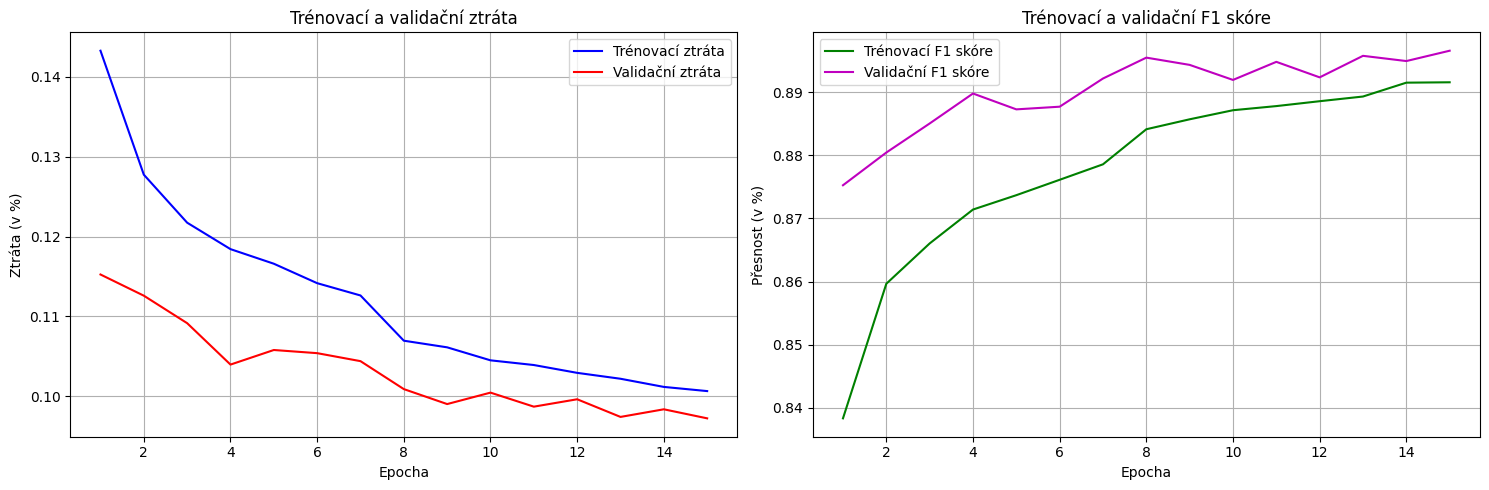

Čas pro vytrénování modelu v 15 epochách:  1598.7055808027585  minut,  26.64509301337931  hodin


In [123]:
# Inicializace modelu, kritéria, optimizéru a scheduleru
model = PlanetClassifier(num_classes=len(unique_tags)) #model resnet50
criterion = nn.BCEWithLogitsLoss() #pos_weight=class_weights  # Vhodné pro multi-label klasifikaci, sem nám vstupují zvýšené váhy kritických tříd
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

print("Trénování modelu...")
num_epochs = 15
start_time = time.time()
trained_model = train_model(model=model, train_loader=train_loader, val_loader=valid_loader, criterion=criterion, optimizer=optimizer, scheduler=scheduler, num_epochs=num_epochs)
end_time = time.time()
print(f"Čas pro vytrénování modelu v {num_epochs} epochách: ", (end_time - start_time)/60, " minut, ", (end_time - start_time)/60/60, " hodin")


První tréning mi trval celkově skoro 29 hodin, když odečtu přibližně polovinu, co jsem měl notebook v hibernaci, tak to bylo 15 hodin. Při prvním tréningu jsem dosáhl přibližně 89% u trénovacích dat a přibližně 89.5% u validačních dat. Viz křivka, kde je zobrazený průběh tréningu v jednotlivých etapách, kde u validačních dat to bylo proměnlivé. Při prvním tréningu jsem narazil na problém, že některé třídy mají pořád 0 F1 skóre, takže není možné, aby je strojové učení detekovalo, i když v průběhu některé nulové tagy dostali svoje F1 skóre. Zřejmě by tady nebylo za špatné zvýšit některým kritikým hodnotám v datasetu, co se tam tolik nevyskytují pravděpodobnosti, aby je bylo schopno strojové učení detekovat, protože mám slabé Macro F1 skóre.
Potom jsem to trochu upravil, zkoušel jsem různá vylepšení jako je konvoluce nebo zvýšení váh kritickým třídám. Nakonec jsem přidal grobal average pooling jenom s jednou vrstvou a ztráta se mi snížila na 90% a Macro skóre se mi zvýšilo z 50 na 56%.

#### Model EfficientNet-b0

In [ ]:
model_2 = EfficientNetGeoClassifier(num_classes=len(unique_tags)) #model resnet50
criterion = nn.BCEWithLogitsLoss()#pos_weight=class_weights)  # Vhodné pro multi-label klasifikaci, sem nám vstupují zvýšené váhy kritických tříd
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5, betas=(0.9,0.999))
num_epochs = 15
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs,eta_min=1e-6)

print("Trénování modelu...")
start_time = time.time()
trained_model_eficientnet = train_model(model=model_2, train_loader=train_loader, val_loader=valid_loader, criterion=criterion, optimizer=optimizer, scheduler=scheduler, num_epochs=num_epochs)
end_time = time.time()
print(f"Čas pro vytrénování modelu v {num_epochs} epochách: ", (end_time - start_time)/60, " minut, ", (end_time - start_time)/60/60, " hodin")


Tady jsem chtěl vyzkoušet jiný model EfficientNet-b0, ale vůbec se nechytal, již při prvním kole i třetího kola měl loss 70%

### Vyhodnocení nejlepšího modelu
Načteme si ten nejlepší trénovací model podle dané třídy modelu.

In [ ]:
model.load_state_dict(torch.load('best_planet_classifier.pth'))

#### Testování modelu
Funkce pro predikci a vytvoření submission souboru pro testovací data na nejlepším modelu. Zde si vytvořím submission soubor, kde se můj model udělá predikce k obrázkům.

In [ ]:
def create_submission(model, test_loader, max_samples):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    predictions = []; image_names = []; processed_samples = 0
    with torch.no_grad():
        for batch, (inputs, _) in enumerate(test_loader):
            if processed_samples >=max_samples: break
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float().cpu().numpy()
            for i in range(len(preds)):
                idx = batch * test_loader.batch_size + i
                if processed_samples < max_samples:
                    img_name = submission_df.iloc[idx]['image_name']
                    image_names.append(img_name)
                    # Získání tagů pro predikci
                    pred_tags = []
                    for j, val in enumerate(preds[i]):
                        if val == 1:
                            pred_tags.append(unique_tags[j])
                    predictions.append(' '.join(pred_tags))
                    processed_samples += 1
    print(f"Zpracováno {processed_samples} vzorků.")
    # Vytvoření submission dataframe
    submit_df = pd.DataFrame({'image_name': image_names, 'tags': predictions })
    # Uložení do CSV
    submit_df.to_csv('submission.csv', index=False)
    print("Submission soubor byl vytvořen!")

#načtení testovacího datasetu
filtered_submission_df = submission_df.head(10000)
filtered_submission_df['tag_vector'] = [np.zeros(len(unique_tags)) for _ in range(len(filtered_submission_df))]
test_dataset = PlanetDataset(filtered_submission_df, TEST_DIR, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

start_time = time.time()
create_submission(trained_model, test_loader, max_samples=10000)
end_time = time.time()
print(f"Čas pro vytvoření submission na testovacích datech.: ", (end_time - start_time)/60, " minut, ", (end_time - start_time)/60/60, " hodin")


C:\Users\imang\AppData\Local\Temp\ipykernel_10460\3161873466.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_submission_df['tag_vector'] = [np.zeros(len(unique_tags)) for _ in range(len(filtered_submission_df))]


Zpracováno 10000 vzorků.
Submission soubor byl vytvořen!
Čas pro vytvoření submission na testovacích datech.:  10.714836525917054  minut,  0.17858060876528423  hodin


#### Vizualizace predikcí ze submission souboru
I když nemám originální tagy k testovacím datům a tím pádem nemůžu udělat udělat nějaké vyhodnocení těchto dat, tak bych aspoň chtěl vizualizovat některé obrázky a predikce k nim, jestli daný opravdu odpovídá tomu, co je na obrázku.

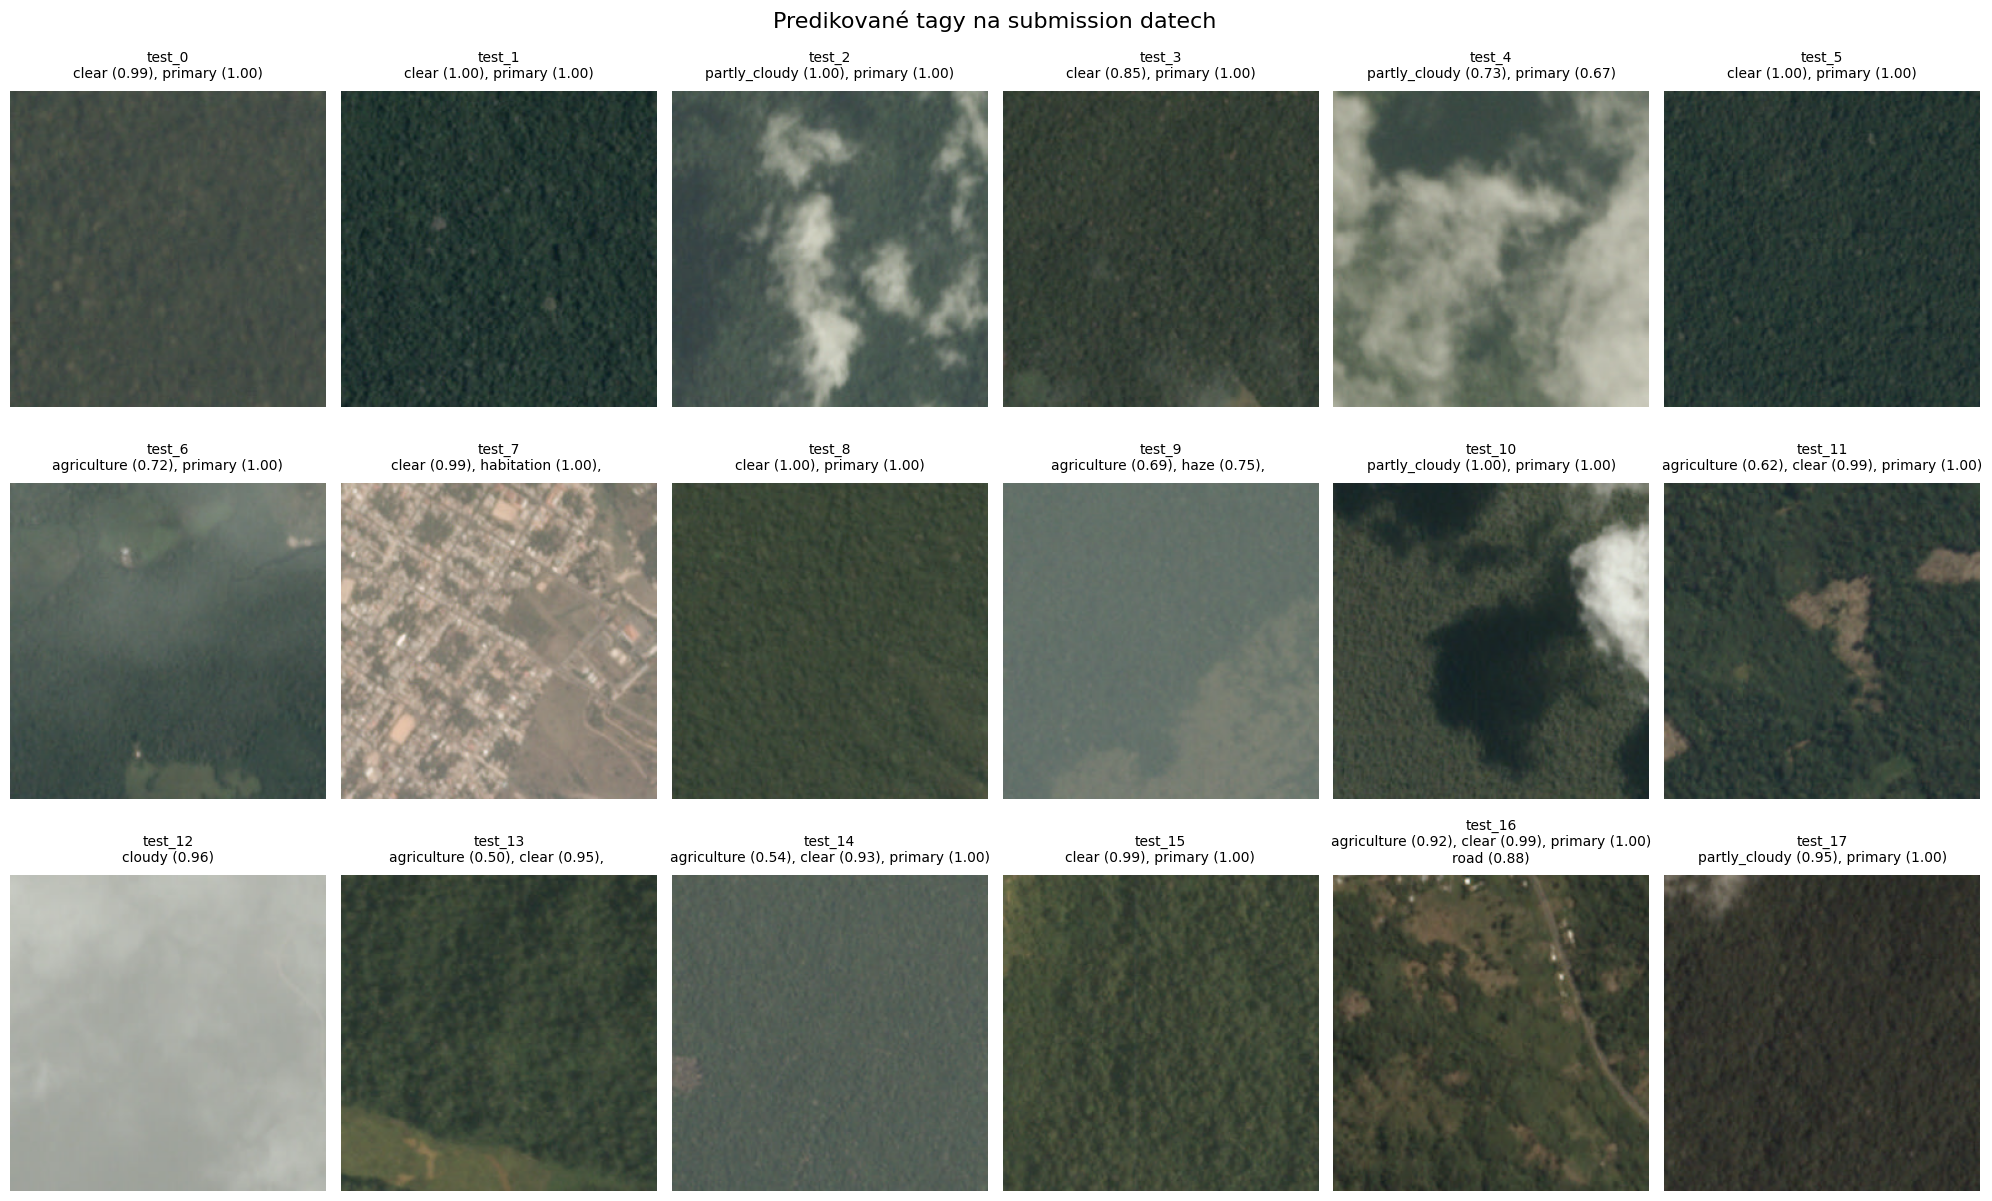

In [190]:
def visualize_predictions(model, test_loader, submission_df, test_dir, unique_tags, num_samples=12, figsize=(15, 12), threshold=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    # Připravíme seznam pro ukládání výsledků
    results = []; processed_samples = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            if processed_samples >= num_samples: break
            # Rozbalení batche podle toho, co obsahuje
            if len(batch) == 2: inputs, _ = batch  # ignorujeme dummy labels
            else: inputs = batch[0]
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float().cpu().numpy()
            # Zpracování každého obrázku v batchi
            for i in range(len(preds)):
                if processed_samples >= num_samples: break
                # Získání indexu obrázku v původním datasetu
                global_idx = batch_idx * test_loader.batch_size + i
                if global_idx < len(submission_df):
                    img_name = submission_df.iloc[global_idx]['image_name']
                    # Získání predikovaných tagů
                    pred_tags = []; pred_probs = []
                    for j, val in enumerate(preds[i]):
                        if val == 1:
                            pred_tags.append(unique_tags[j])
                            pred_probs.append(probs[i][j].item())
                    # Pokud nejsou žádné tagy, vezměme top 3 pravděpodobnosti
                    if not pred_tags:
                        top_indices = np.argsort(probs[i].cpu().numpy())[-3:][::-1]
                        for idx in top_indices:
                            pred_tags.append(f"{unique_tags[idx]} ({probs[i][idx].item():.3f})")
                    results.append({'image_name': img_name, 'predicted_tags': pred_tags, 'probabilities': pred_probs })
                    processed_samples += 1
    # Vytvoření vizualizace
    rows = (num_samples + 3) // 6
    cols = min(6, num_samples)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)
    for idx, result in enumerate(results):
        row = idx // cols
        col = idx % cols
        img_path = os.path.join(test_dir, result['image_name'] + '.jpg')
        image = Image.open(img_path).convert('RGB')
        axes[row, col].imshow(image)
        axes[row, col].axis('off')
        if result['predicted_tags']:
            if result['probabilities']:
                title_parts = []
                for tag, prob in zip(result['predicted_tags'], result['probabilities']):
                    title_parts.append(f"{tag} ({prob:.2f})")
                title = ', '.join(title_parts[:2])  # max 2 tagy
                if len(title_parts)>2:
                    title += ', '
                    title+="\n".join(title_parts[3:5])
            else:
                title = '\n'.join(result['predicted_tags'][:3]) # Jen názvy tagů
        else:
            title = "Žádné tagy"
        axes[row, col].set_title(f"{result['image_name']}\n{title}", fontsize=10, pad=10)

    # Skrytí prázdných subplotů
    for idx in range(len(results), rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].axis('off')
    plt.tight_layout(); plt.suptitle('Predikované tagy na submission datech', fontsize=16, y=1.02); plt.show()

visualize_predictions(trained_model, test_loader, filtered_submission_df, TEST_DIR, unique_tags, num_samples=18, figsize=(20, 12), threshold=0.5)

Já myslím, že model ty obrázky rozpoznává dobře. Umí označit všechno, kde je Primary - les, agriculture - nějaké pole, habitation - nějaké domy, cloudy - zamračeno, partly_cloudy - částečně zamračeno, clear - čisté nebo road - silnice.

#### Confusion matrices na validačních datech
Nyní si pomocí validačních dat zobrazím confusion matrices. Confucion matrix ke každému tagu na každý tag a potom celkový confusion matrix.

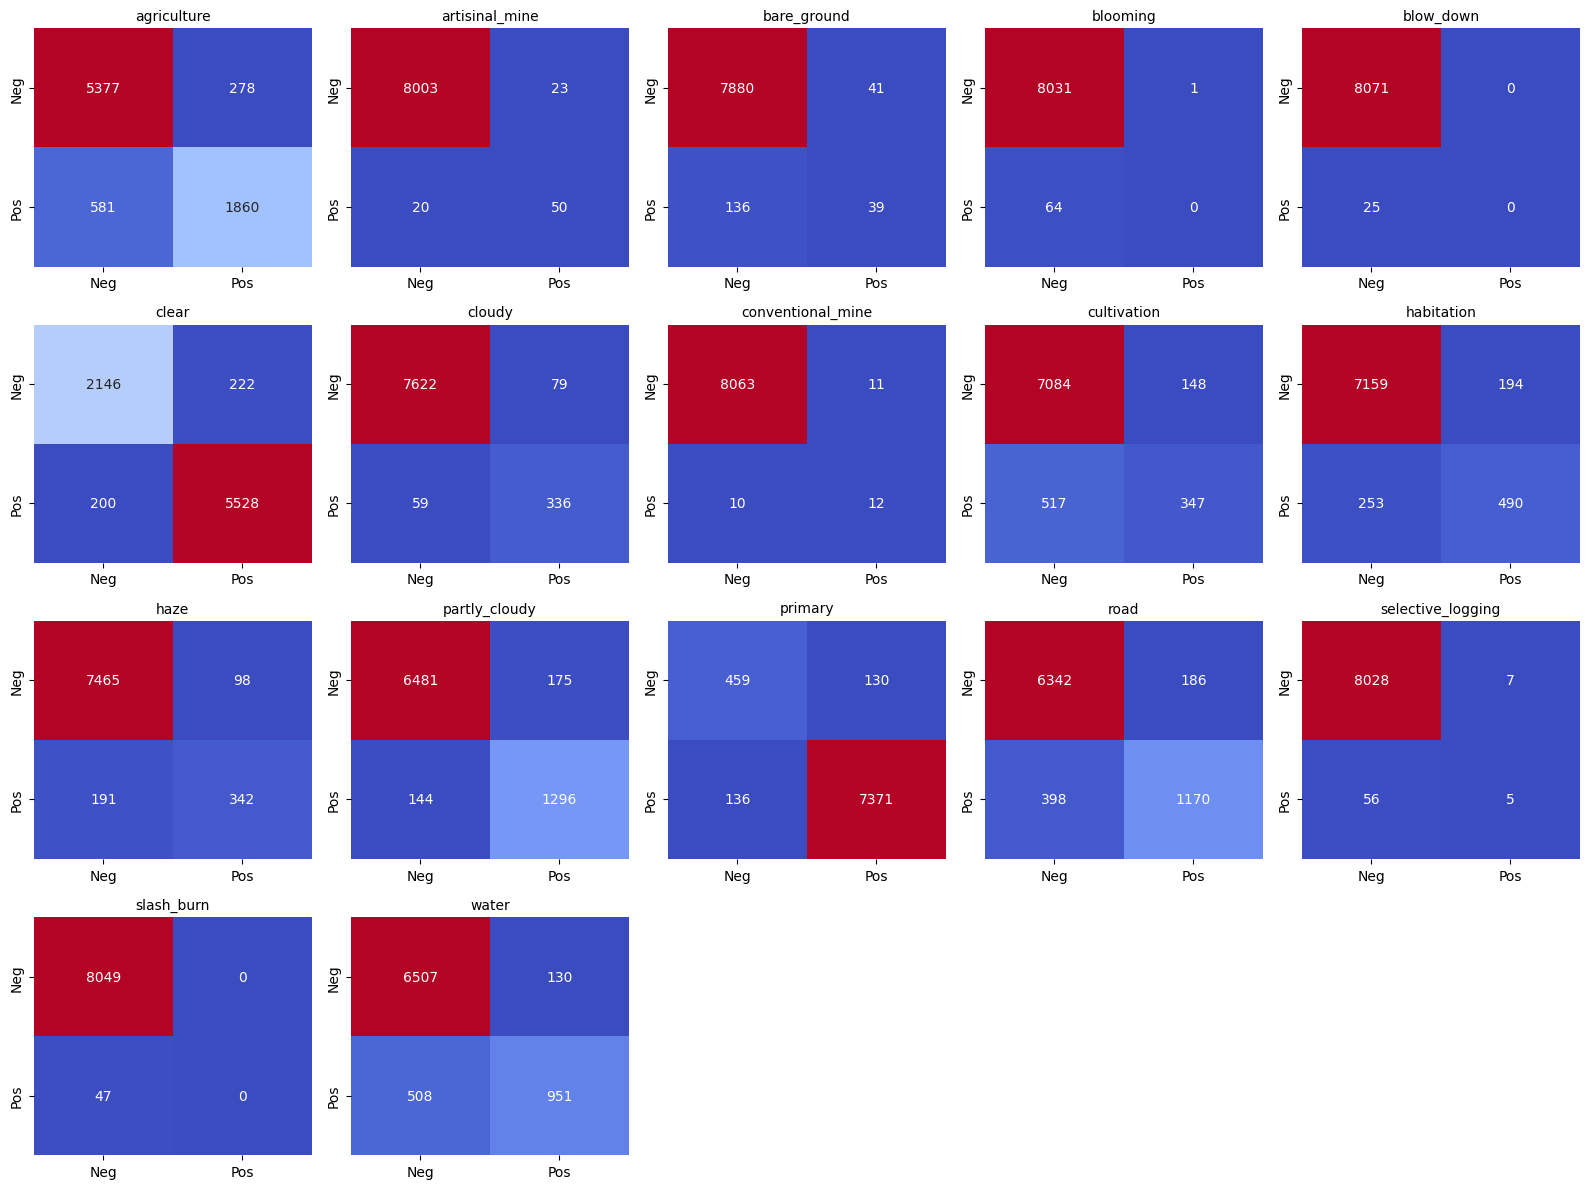

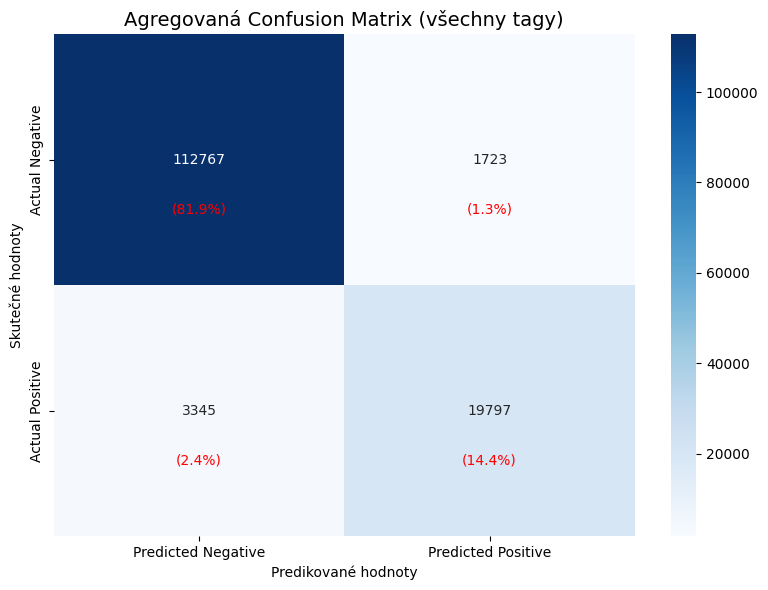

DETAILNÍ PŘEHLED VÝSLEDKŮ PRO VŠECHNY TAGY
Rank Tag                  Precision  Recall   F1-Score  Support 
----------------------------------------------------------------------
1    primary              0.983      0.982    0.982     7507    
2    clear                0.961      0.965    0.963     5728    
3    partly_cloudy        0.881      0.900    0.890     1440    
4    cloudy               0.810      0.851    0.830     395     
5    agriculture          0.870      0.762    0.812     2441    
6    road                 0.863      0.746    0.800     1568    
7    water                0.880      0.652    0.749     1459    
8    haze                 0.777      0.642    0.703     533     
9    artisinal_mine       0.685      0.714    0.699     70      
10   habitation           0.716      0.659    0.687     743     
11   conventional_mine    0.522      0.545    0.533     22      
12   cultivation          0.701      0.402    0.511     864     
13   bare_ground          0.487      0.22

In [183]:
def evaluate_model_with_confusion_matrix(model, data_loader, unique_tags):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    all_preds = []; all_labels = []; processed_samples = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    # Spojení všech dávek
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    # GRID LAYOUT - Všechny tagy v jednom obrázku
    n_tags = len(unique_tags)
    n_cols = 5  # Počet sloupců v gridu
    n_rows = (n_tags + n_cols - 1) // n_cols  # Výpočet počtu řádků
    plt.figure(figsize=(16, 3 * n_rows))
    binary_cm = multilabel_confusion_matrix(all_labels, all_preds) #true hodnoty, predikáty
    for i in range(n_tags):
        plt.subplot(n_rows, n_cols, i + 1)
        cm = binary_cm[i]
        sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'], cbar=False)
        plt.title(f'{unique_tags[i]}', fontsize=10)
        plt.xlabel('')
        plt.ylabel('')
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.tight_layout(); plt.savefig('all_tags_confusion_matrix_grid.png', dpi=300, bbox_inches='tight'); plt.show(); plt.close()
    # KOMPAKTNÍ CONFUSION MATRIX - Agregované hodnoty
    # Výpočet agregovaných hodnot
    total_tp = np.sum([binary_cm[i][1,1] for i in range(n_tags)])
    total_fp = np.sum([binary_cm[i][0,1] for i in range(n_tags)])
    total_fn = np.sum([binary_cm[i][1,0] for i in range(n_tags)])
    total_tn = np.sum([binary_cm[i][0,0] for i in range(n_tags)])
    # Vytvoření agregované confusion matrix
    aggregated_cm = np.array([[total_tn, total_fp], [total_fn, total_tp]])
    plt.figure(figsize=(8, 6))
    sns.heatmap(aggregated_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Agregovaná Confusion Matrix (všechny tagy)', fontsize=14); plt.ylabel('Skutečné hodnoty'); plt.xlabel('Predikované hodnoty')
    # Přidání procent
    total = np.sum(aggregated_cm)
    for i in range(2):
        for j in range(2):
            percentage = (aggregated_cm[i,j] / total) * 100
            plt.text(j+0.5, i+0.7, f'({percentage:.1f}%)', ha='center', va='center', fontsize=10, color='red')
    plt.tight_layout(); plt.savefig('aggregated_confusion_matrix.png', dpi=300, bbox_inches='tight'); plt.show(); plt.close()
    # 5. INTERAKTIVNÍ TABULKA S DETAILY
    print("="*80)
    print("DETAILNÍ PŘEHLED VÝSLEDKŮ PRO VŠECHNY TAGY")

    precisions = []; recalls = []; f1_scores = []; supports = []
    for i in range(n_tags):
        cm = binary_cm[i]
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        support = tp + fn
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        supports.append(support)
    metrics_df = pd.DataFrame({'Tag': unique_tags, 'Precision': precisions, 'Recall': recalls, 'F1-Score': f1_scores, 'Support': supports})
    metrics_df_sorted = metrics_df.sort_values('F1-Score', ascending=False)
    print(f"{'Rank':<4} {'Tag':<20} {'Precision':<10} {'Recall':<8} {'F1-Score':<9} {'Support':<8}")
    print("-" * 70)
    for idx, (_, row) in enumerate(metrics_df_sorted.iterrows()):
        print(f"{idx+1:<4} {row['Tag']:<20} {row['Precision']:<10.3f} {row['Recall']:<8.3f} {row['F1-Score']:<9.3f} {row['Support']:<8.0f}")
    # Celkové statistiky
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)
    print("\n"+"="*50)
    print("CELKOVÉ STATISTIKY")
    print(f"Průměrná Precision: {avg_precision:.4f}")
    print(f"Průměrný Recall:    {avg_recall:.4f}")
    print(f"Průměrný F1 Score:  {avg_f1:.4f}")
    print(f"Celkový počet tagů: {len(unique_tags)}")
    return metrics_df_sorted

start_time = time.time()
df_metrics = evaluate_model_with_confusion_matrix(trained_model, valid_loader, unique_tags)
end_time = time.time()
print(f"Čas pro vytvoření confusion matrices na testovacích datech.: ", (end_time - start_time)/60, " minut, ", (end_time - start_time)/60/60, " hodin")


#### Testování modelu na vytvořených testovacích datech z validačních dat
Teď si vytvořím data se skutečnými labely z validačních dat, kde i bude správý název a přidaná predikovaná hodnota modelem. To dále potom můžu porovnat. 

In [249]:
# Třída pro načtení datasetu pro testovací data
class TestDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.transform = transform
        # Kontrola existence sloupce tags při inicializaci
        if 'tags' not in self.data.columns:
            raise ValueError("Chybí sloupec 'tags' v CSV souboru pro testovací data.")
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['image_name']
        img_path = os.path.join(self.img_dir, img_name+".jpg")
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Načtení tagů jako string (oddělených mezerou)
        tags_string = self.data.iloc[idx]['tags']
        # tags_list = tags_string.split() if isinstance(tags_string, str) else []
        return image, tags_string, img_name

# otestování modelu na submission datech
def test_model_multilabel(model, test_loader, threshold=0.5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    all_predictions = []; all_labels = []; all_image_names = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            if len(batch) == 3:
                images, labels, img_names = batch
                # Pro multi-label ukládáme originální tagy
                all_labels.extend(labels)
            else:
                print("Nejsou labely")
                return
            images = images.to(device)
            outputs = model(images)
            # Pro multi-label klasifikaci použijeme sigmoid
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > threshold).float()

            all_predictions.extend(predictions.cpu().numpy())
            all_image_names.extend(img_names)

    return all_predictions, all_labels, all_image_names

#rozdělení validačních dat na testovací
_, test_data = train_test_split(valid_data, test_size=0.5, random_state=42)
#otestování modelu na testovacích datech
test_dataset = TestDataset(test_data, TRAIN_DIR, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
predictions, true_labels, image_names = test_model_multilabel(trained_model, test_loader)

#### Vyhodnocení modelu na testovacích datech a zobrazení špatně klasifikovaných obrázků

Celková přesnost: 0.6376 (63.76%)

Detailní metriky pro každou třídu:
                   precision    recall  f1-score   support

      agriculture       0.87      0.76      0.81      1218
   artisinal_mine       0.72      0.72      0.72        36
      bare_ground       0.54      0.24      0.33        92
         blooming       0.00      0.00      0.00        32
        blow_down       0.00      0.00      0.00        16
            clear       0.96      0.97      0.96      2858
           cloudy       0.78      0.84      0.81       188
conventional_mine       0.42      0.50      0.45        10
      cultivation       0.70      0.41      0.52       430
       habitation       0.73      0.65      0.69       361
             haze       0.80      0.64      0.71       267
    partly_cloudy       0.89      0.89      0.89       735
          primary       0.98      0.98      0.98      3762
             road       0.87      0.76      0.82       778
selective_logging       0.43      0.10      

c:\Users\imang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\imang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


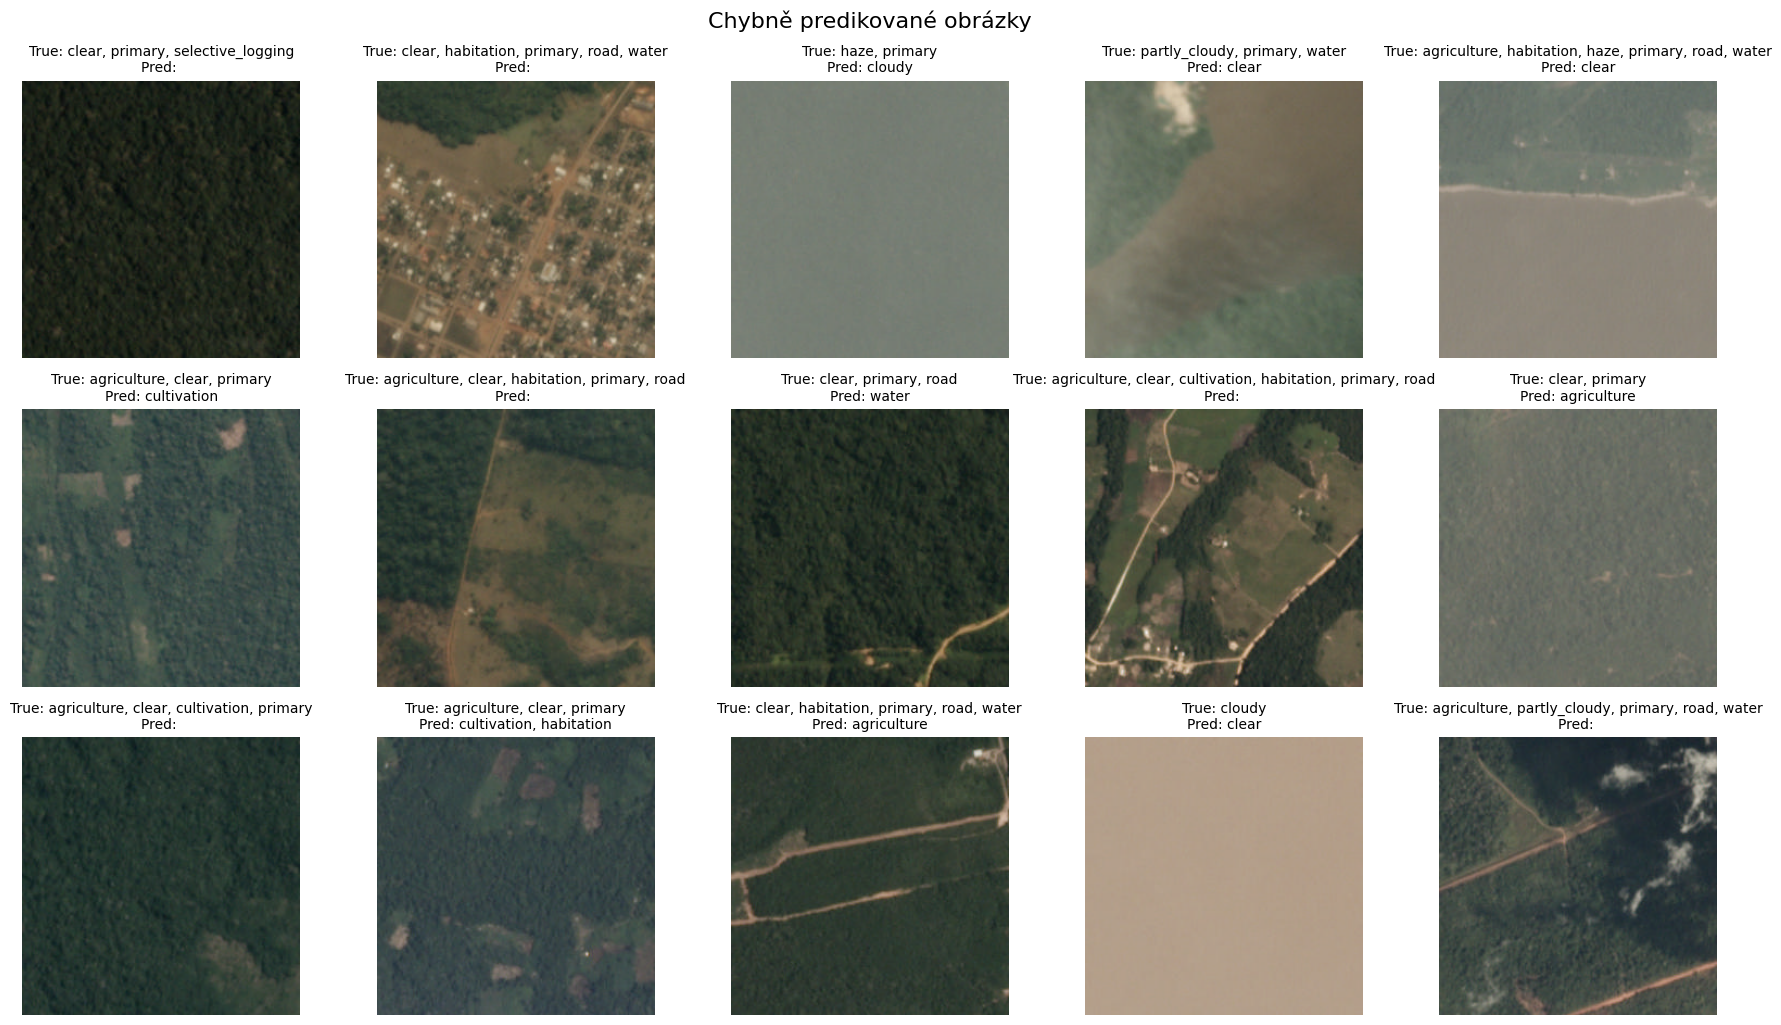

In [255]:
def analyze_results(y_true, y_pred, class_names, image_names=None):
    #převedení labelů do správného formátu
    mlb = MultiLabelBinarizer(classes=class_names)
    mlb.fit([class_names])
    if isinstance(y_true[0], str):
        # Pokud jsou to stringy s tagy oddělenými mezerou
        y_true_lists = []
        for label in y_true:
            tags = label.split() if label.strip() else []
            # Filtrujeme jen známé tagy
            valid_tags = [tag for tag in tags if tag in unique_tags]
            y_true_lists.append(valid_tags)
        y_true = mlb.transform(y_true_lists)
    elif isinstance(y_true, np.ndarray) and y_true.ndim == 2:
        # Už je to binary matrix
        y_true = y_true
    else:
        print("Převedeno na jiný formát")
        y_true = mlb.transform(y_true)

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Celková přesnost: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print("\nDetailní metriky pro každou třídu:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    # Najít špatně klasifikované obrázky
    if image_names is not None:
        misclassified = []
        for i, (true_label, pred_label, img_name) in enumerate(zip(y_true, y_pred, image_names)):
            pred_label = np.array(pred_label, dtype=int)
            if not np.array_equal(true_label, pred_label):
                #print(f"Špatně klasifikovaný obrázek: {img_name}")
                misclassified.append({
                    'image': img_name,
                    'true_class': ", ".join([class_names[idx] for idx, val in enumerate(true_label) if val == 1]),
                    'predicted_class': ", ".join([class_names[idx] for idx, val in enumerate(pred_label) if val == 1 and true_label[idx] == 0])
                })
        print(f"\nPočet špatně klasifikovaných obrázků: {len(misclassified)}")
        # Zobrazit prvních 10 špatně klasifikovaných
        if misclassified:
            print("\nPrvních 15 špatně klasifikovaných obrázků:")
            for i, item in enumerate(misclassified[:15]):
                print(f"{i+1}. {item['image']}: {item['true_class']} → {item['predicted_class']}")
        return misclassified
    return None

def visualize_misclassified_samples(misclassified_list, img_dir, n_samples=15):
    if not misclassified_list:
        print("Žádné špatně klasifikované obrázky!")
        return
    n_samples = min(n_samples, len(misclassified_list))
    fig, axes = plt.subplots(3, n_samples//3, figsize=(18, 10))
    axes = axes.flatten()
    for i in range(n_samples):
        img_info = misclassified_list[i]
        img_path = os.path.join(img_dir, img_info['image']+".jpg")
        try:
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"True: {img_info['true_class']}\nPred: {img_info['predicted_class']}",fontsize=10)
            axes[i].axis('off')
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Error loading\n{img_info['image']}",ha='center', va='center')
            axes[i].axis('off')

    plt.tight_layout(); plt.suptitle('Chybně predikované obrázky', fontsize=16, y=1.02); plt.show()

if true_labels:
    # analyzujeme výsledky
    misclassified = analyze_results(true_labels, predictions, unique_tags, image_names=image_names)
    # vizualizujeme si špatně klasifikované obrázky
    visualize_misclassified_samples(misclassified,TRAIN_DIR)


Jak jsem zjistil, tak některé obrázky můžou prostě být špatně popsány nebo není na nich nic.